# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two approaches to DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [1]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


Upload the swda.zip to google colab and then run the next cell

In [3]:
!unzip swda.zip

Archive:  swda.zip
   creating: swda/
  inflating: swda/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/swda/
  inflating: __MACOSX/swda/._.DS_Store  
   creating: swda/sw00utt/
  inflating: swda/sw00utt/sw_0001_4325.utt.csv  
   creating: __MACOSX/swda/sw00utt/
  inflating: __MACOSX/swda/sw00utt/._sw_0001_4325.utt.csv  
  inflating: swda/sw00utt/sw_0002_4330.utt.csv  
  inflating: swda/sw00utt/sw_0003_4103.utt.csv  
  inflating: swda/sw00utt/sw_0004_4327.utt.csv  
  inflating: swda/sw00utt/sw_0005_4646.utt.csv  
  inflating: swda/sw00utt/sw_0006_4108.utt.csv  
  inflating: swda/sw00utt/sw_0007_4171.utt.csv  
  inflating: swda/sw00utt/sw_0008_4321.utt.csv  
  inflating: swda/sw00utt/sw_0009_4329.utt.csv  
  inflating: swda/sw00utt/sw_0010_4356.utt.csv  
  inflating: swda/sw00utt/sw_0011_4358.utt.csv  
  inflating: swda/sw00utt/sw_0012_4360.utt.csv  
  inflating: swda/sw00utt/sw_0013_4617.utt.csv  
  inflating: swda/sw00utt/sw_0014_4619.utt.csv  
  inflating: swda/sw00u

In [0]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [5]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [0]:
reduced_df = result[['act_tag','text']]

Reduce down the number of tags to 43 - converting the combined tags to their generic classes:

In [0]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [8]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


There are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


To get unique tags:

In [0]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [0]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))

In [0]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [0]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [0]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [0]:
# Max length of 137
MAX_LENGTH = len(max(sentences, key=len))

In [0]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [0]:
MAX_LENGTH = 137

In [0]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

In [0]:
train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]

# Model 1 - 

The first approach we'll try is to treat DA tagging as a standard multi-class text classification task, in the way you've done before with sentiment analysis and other tasks. Each utterance will be treated independently as a text to be classified with its DA tag label. This model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get the probabilities.


In [0]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

**The model below is created with one embedding layer, two biLSTM Layers and one dense layer and softmax activation layer. Adam optimiser is used with categorical_crossentropy loss for multiclass classification. This model treats the problem as a multiclass classification problem.**



In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam

#Building the network
# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states
model = Sequential()
# Embedding layer with output size = EMBED_SIZE
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_LENGTH))
# Bidirectional 1 returns the full sequence
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
# Bidirectional 2
model.add(Bidirectional(LSTM(HIDDEN_SIZE)))
# Dense layer
model.add(Dense(HIDDEN_SIZE))
# Activation - softmax for multiclass classification
model.add(Activation('softmax'))
optimizer = Adam()


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 137, 100)          4373100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                3741      
_________________________________________________________________
activation_1 (Activation)    (None, 43)                0         
Total params: 4,471,097
Trainable params: 4,471,097
Non-trainable params: 0
_________________________________________________________________


**The layers of the model are given below**

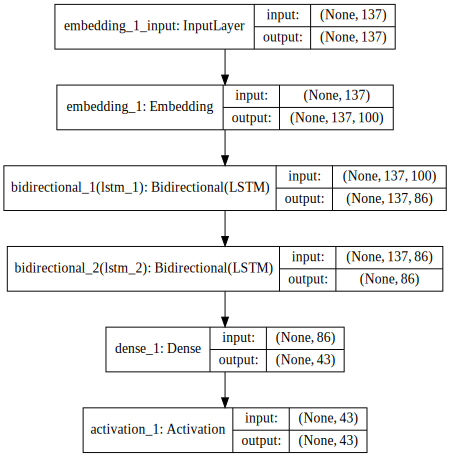

In [23]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi='70').create(prog='dot', format='svg'))

**The model is trained until the val_accuracy starts to decrease. The callback of the fit function, called "EarlyStopping" is used. This stops the training as soon as the val_accuracy is lower for the next three epochs. The weights from the best epoch is restored.**

In [25]:
# Train the model - using validation 
from keras.callbacks import EarlyStopping
history = model.fit(x=train_input, y=train_labels, epochs=50, batch_size=500, validation_data=(val_input, val_labels),
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140000 samples, validate on 27704 samples
Epoch 1/50
140000/140000 [==============================] - 232s 2ms/step - loss: 1.7840 - accuracy: 0.5106 - val_loss: 1.3520 - val_accuracy: 0.6131
Epoch 2/50
140000/140000 [==============================] - 227s 2ms/step - loss: 1.2152 - accuracy: 0.6491 - val_loss: 1.1308 - val_accuracy: 0.6683
Epoch 3/50
140000/140000 [==============================] - 232s 2ms/step - loss: 1.0203 - accuracy: 0.7024 - val_loss: 1.0452 - val_accuracy: 0.6846
Epoch 4/50
140000/140000 [==============================] - 229s 2ms/step - loss: 0.9164 - accuracy: 0.7324 - val_loss: 1.0232 - val_accuracy: 0.6957
Epoch 5/50
140000/140000 [==============================] - 228s 2ms/step - loss: 0.8527 - accuracy: 0.7499 - val_loss: 1.0135 - val_accuracy: 0.6963
Epoch 6/50
140000/140000 [==============================] - 226s 2ms/step - loss: 0.7990 - accuracy: 0.7645 - val_loss: 1.0268 - val_accuracy: 0.6949
Epoch 7/50
140000/140000 [=======================

In [27]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 38s 685us/step


In [28]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 69.99570727348328


## Evaluation


The overall accuracy is 67%, an effective accuracy for this task.

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？

## Minority Classes

In [0]:
# Generate predictions for the test data
predictions = model.predict(test_sentences_X, batch_size=100)

In [0]:
# Build the confusion matrix off these predictions
matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

**Get the acuracy of the minority classes as given below.**

In [33]:
acc_class = matrix.diagonal()/matrix.sum(axis=1)

index_br = list(one_hot_encoding_dic["br"][one_hot_encoding_dic["br"]==1].index)[0]
br_accuracy = acc_class[index_br]*100
print("br accuracy: {}".format(br_accuracy))

index_bf = list(one_hot_encoding_dic["bf"][one_hot_encoding_dic["bf"]==1].index)[0]
bf_accuracy = acc_class[index_bf]*100
print("bf accuracy: {}".format(bf_accuracy))

br accuracy: 35.44303797468354
bf accuracy: 0.7843137254901961



Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. 




# Model 2 - Balanced Network


One thing we can do to try to improve performance is therefore to balance the data more sensibly. As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [0]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [37]:
# Re-built the model for the balanced training
# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states
model_balanced = Sequential()
# Embedding layer
model_balanced.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_LENGTH))
# Bidirectional 1
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
# Bidirectional 2
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE)))
# Dense layer
model_balanced.add(Dense(HIDDEN_SIZE))
# Activation
model_balanced.add(Activation('softmax'))
optimizer = Adam()

model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_balanced.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 137, 100)          4373100   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense_2 (Dense)              (None, 43)                3741      
_________________________________________________________________
activation_2 (Activation)    (None, 43)                0         
Total params: 4,471,097
Trainable params: 4,471,097
Non-trainable params: 0
_________________________________________________________________


**Adding class_weight=d_class_weights for a balanced model. This adds a higher penalty for the missclassification of minority classes. This weights the loss function during training. It is used to pay more attention to the minority classes.**

In [38]:
# Train the balanced network -  takes  time to achieve good accuracy
from keras.callbacks import EarlyStopping
history_balanced = model_balanced.fit(train_input, train_labels, epochs=50, batch_size=500, validation_data=(val_input, val_labels), class_weight=d_class_weights,
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140000 samples, validate on 27704 samples
Epoch 1/50
140000/140000 [==============================] - 226s 2ms/step - loss: 3.3579 - accuracy: 0.2058 - val_loss: 2.6354 - val_accuracy: 0.3773
Epoch 2/50
140000/140000 [==============================] - 227s 2ms/step - loss: 2.6509 - accuracy: 0.2871 - val_loss: 2.4719 - val_accuracy: 0.3220
Epoch 3/50
140000/140000 [==============================] - 225s 2ms/step - loss: 2.2069 - accuracy: 0.3433 - val_loss: 2.2544 - val_accuracy: 0.3927
Epoch 4/50
140000/140000 [==============================] - 224s 2ms/step - loss: 1.8555 - accuracy: 0.3905 - val_loss: 2.1579 - val_accuracy: 0.3867
Epoch 5/50
140000/140000 [==============================] - 225s 2ms/step - loss: 1.6041 - accuracy: 0.3984 - val_loss: 2.0842 - val_accuracy: 0.3859
Epoch 6/50
140000/140000 [==============================] - 224s 2ms/step - loss: 1.3985 - accuracy: 0.4398 - val_loss: 1.9088 - val_accuracy: 0.4563
Epoch 7/50
140000/140000 [=======================

## Test the model

In [39]:
# Overall Accuracy
score = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 39s 690us/step


In [40]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 45.79800367355347


In [0]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [42]:
# Build the confusion matrix off these predictions

matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
acc_class_balanced = matrix_balanced.diagonal()/matrix_balanced.sum(axis=1)

index_br = list(one_hot_encoding_dic["br"][one_hot_encoding_dic["br"]==1].index)[0]
br_accuracy = acc_class_balanced[index_br]*100
print("br accuracy: {}".format(br_accuracy))

index_bf = list(one_hot_encoding_dic["bf"][one_hot_encoding_dic["bf"]==1].index)[0]
bf_accuracy = acc_class_balanced[index_bf]*100
print("bf accuracy: {}".format(bf_accuracy))
# Calculate Accuracies for "br" and "bf"



br accuracy: 46.835443037974684
bf accuracy: 14.117647058823529


**The overall accuracy of the balanced model is lower than the accuracy of the unbalanced model. But the individual classes have a much better accuracy in balanced model than in unbalanced model. In balanced model, there is a higher penalty when the classification of minority classes goes wrong. Hence the overall accuracy is lower.**



### Accuracies



### Explanation


### Other ways to handle imbalanced classes


- Over-sampling: this means to increase instances of minority classes on the training set by duplication. The advantage is that no information is lost. The disadvantage is that the model becomes prone to overfitting.

- Under-sampling: This means to decrease the instances of majority classes until it is comparable with the minority class. As this method removes the data from dataset, useful information may be lost. 

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification

The second approach we will try is a hierarchical approach to DA tagging. We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification, acting like the text classifier from Model 1 above. Then we use a bidirectional-LSTM (BLSTM) above that to learn how to use the context before and after the current utterance to improve the output.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output



## CNN


This is a classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [0]:
from keras.layers import Input, Reshape, Conv2D, BatchNormalization, MaxPool2D, concatenate, Flatten
from keras.models import Model

filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
merged_1 = concatenate([maxpool_0, maxpool_1, maxpool_2])

# flatten concatenated tensors
# applying time distributed layer so that cnn output is compatible with BiLSTM input
flat = TimeDistributed(Flatten())(merged_1)
# dense layer (dense_1)
dense_1 = Dense(HIDDEN_SIZE, activation='relu')(flat)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)


## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.

In [0]:
# BLSTM model
# using CNN + dense + dropout's output as input to the BiLSTM layer.
biLSTM1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences='true'))(dropout_1)
# Bidirectional 2
biLSTM2 = Bidirectional(LSTM(HIDDEN_SIZE))(biLSTM1)
# Dense layer (dense_2)
dense_2 = Dense(HIDDEN_SIZE, activation='relu')(biLSTM2)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer

In [45]:
# concatenate 2 final layers
# flatten the output of the CNN + dense + dropout so that it can be concatenated with the output of BiLSTM
dropout_flat = Flatten()(dropout_1)
# concatenating the output of CNN + dense + dropout with the output of BiLSTM + dense + dropout
merged_2 = concatenate([dropout_flat, dropout_2])
# merged_2 has the dimension of (None, 86)
# adding a dense layer to get the output of the dim (None, 43) for the multiclass classification problem
dense_3 = Dense(units=HIDDEN_SIZE, input_shape=(1,))(merged_2)
# adding softmax for multiclass classification
output = Activation('softmax')(dense_3)

optimizer = Adam()

model_cnn = Model(inputs=[inputs], outputs=[output])
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_cnn.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 137)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 137, 100)     4373100     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 137, 100, 1)  0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 135, 1, 64)   19264       reshape_1[0][0]                  
____________________________________________________________________________________________

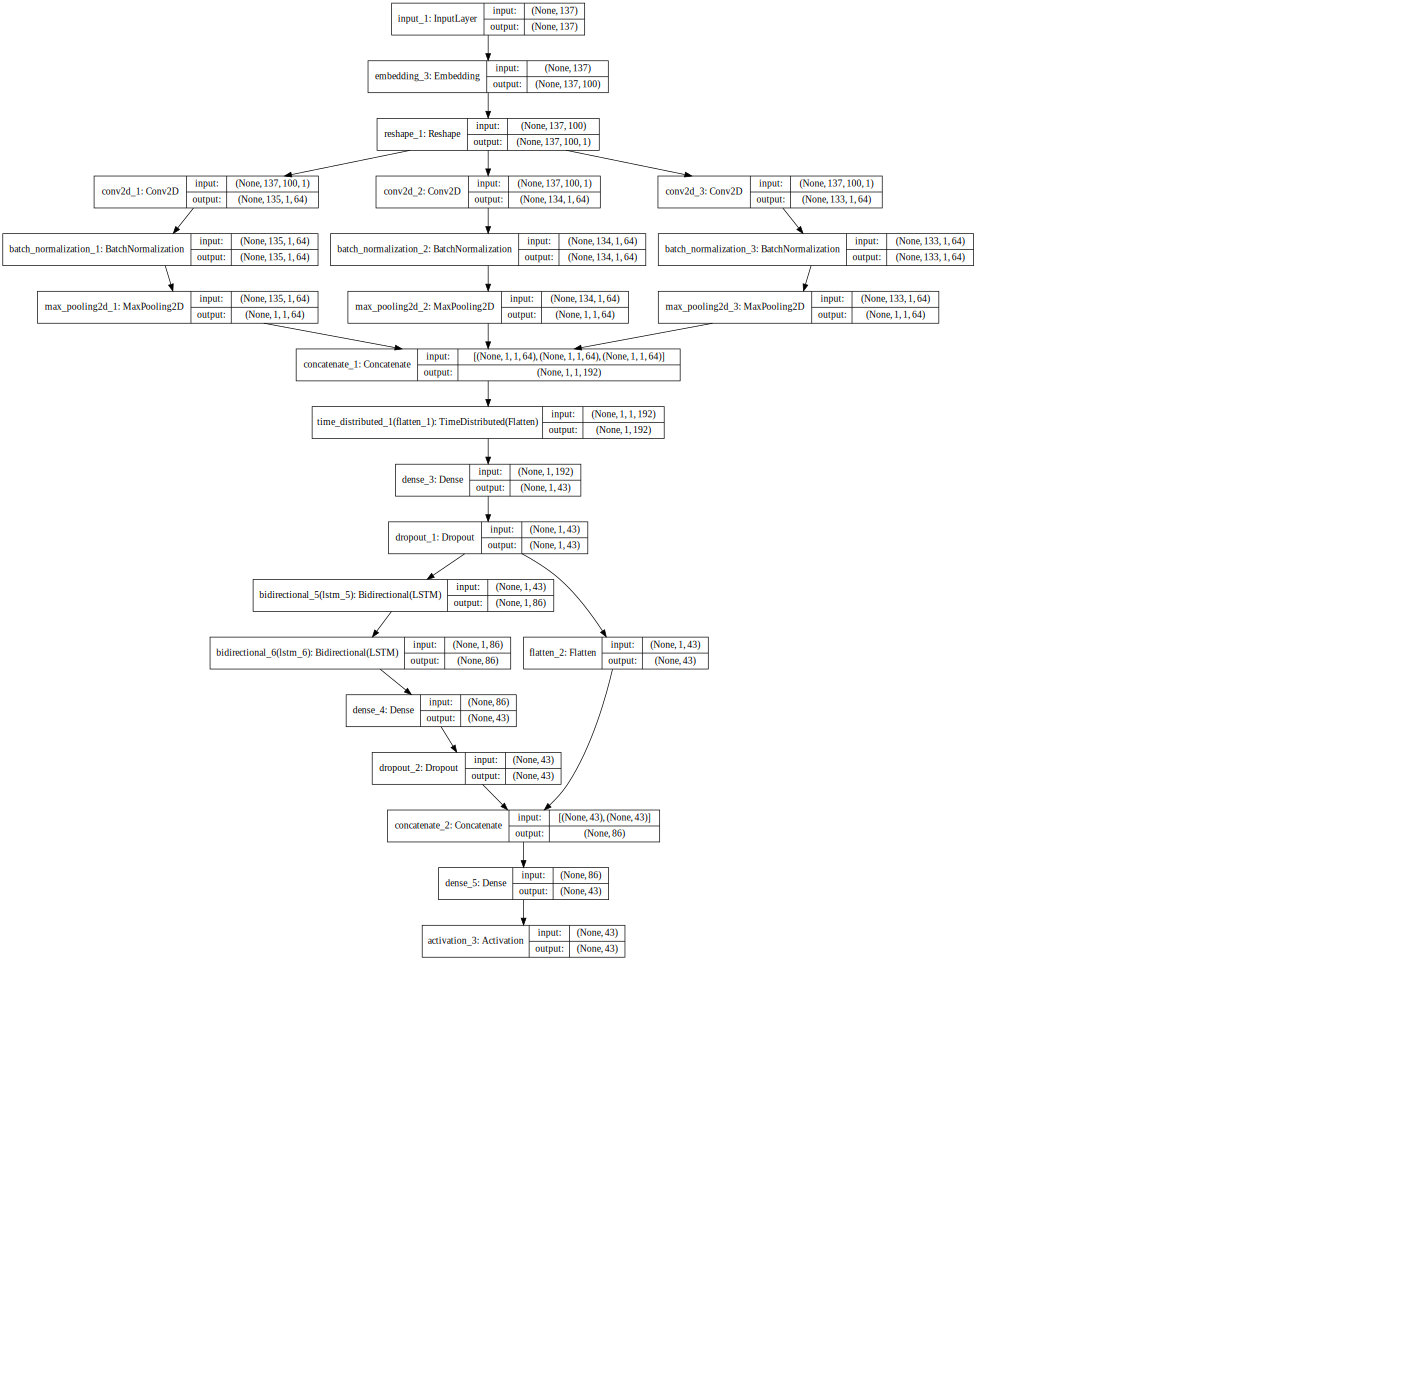

In [46]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model_cnn, show_shapes=True, show_layer_names=True, dpi='50').create(prog='dot', format='svg'))

In [47]:
# Train the model - using validation 
from keras.callbacks import EarlyStopping
history = model_cnn.fit(train_input, train_labels, epochs=50, batch_size=500, validation_data=(val_input, val_labels), 
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140000 samples, validate on 27704 samples
Epoch 1/50
140000/140000 [==============================] - 19s 137us/step - loss: 1.3496 - accuracy: 0.6248 - val_loss: 2.5050 - val_accuracy: 0.5544
Epoch 2/50
140000/140000 [==============================] - 12s 89us/step - loss: 0.9035 - accuracy: 0.7272 - val_loss: 1.1382 - val_accuracy: 0.7048
Epoch 3/50
140000/140000 [==============================] - 12s 89us/step - loss: 0.7304 - accuracy: 0.7764 - val_loss: 0.9732 - val_accuracy: 0.7060
Epoch 4/50
140000/140000 [==============================] - 13s 89us/step - loss: 0.6143 - accuracy: 0.8101 - val_loss: 1.0310 - val_accuracy: 0.7039
Epoch 5/50
140000/140000 [==============================] - 12s 89us/step - loss: 0.5393 - accuracy: 0.8304 - val_loss: 1.1091 - val_accuracy: 0.6996
Epoch 6/50
140000/140000 [==============================] - 13s 89us/step - loss: 0.4859 - accuracy: 0.8454 - val_loss: 1.1976 - val_accuracy: 0.6986
Restoring model weights from the end of the best

In [48]:
score = model_cnn.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 2s 43us/step


In [0]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 70.81320881843567


### Minority Classes



In [49]:
predictions_cnn = model_cnn.predict(test_sentences_X, batch_size=100)
matrix_cnn = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions_cnn.argmax(axis=1))
acc_class_cnn = matrix_cnn.diagonal()/matrix_cnn.sum(axis=1)

index_br = list(one_hot_encoding_dic["br"][one_hot_encoding_dic["br"]==1].index)[0]
br_accuracy = acc_class_cnn[index_br]*100
print("br accuracy: {}".format(br_accuracy))

index_bf = list(one_hot_encoding_dic["bf"][one_hot_encoding_dic["bf"]==1].index)[0]
bf_accuracy = acc_class_cnn[index_bf]*100
print("bf accuracy: {}".format(bf_accuracy))

br accuracy: 37.9746835443038
bf accuracy: 0.0


# CNN balanced

Balanced CNN+BiLSTM model - architecture remains the same

In [50]:
from keras.layers import Input, Reshape, Conv2D, BatchNormalization, MaxPool2D, concatenate, Flatten
from keras.models import Model

filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
merged_1 = concatenate([maxpool_0, maxpool_1, maxpool_2])

# flatten concatenated tensors
# applying time distributed layer so that cnn output is compatible with BiLSTM input
flat = TimeDistributed(Flatten())(merged_1)
# dense layer (dense_1)
dense_1 = Dense(HIDDEN_SIZE, activation='relu')(flat)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

# BLSTM model
# using CNN + dense + dropout's output as input to the BiLSTM layer.
biLSTM1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences='true'))(dropout_1)
# Bidirectional 2
biLSTM2 = Bidirectional(LSTM(HIDDEN_SIZE))(biLSTM1)
# Dense layer (dense_2)
dense_2 = Dense(HIDDEN_SIZE, activation='relu')(biLSTM2)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)

# concatenate 2 final layers
# flatten the output of the CNN + dense + dropout so that it can be concatenated with the output of BiLSTM
dropout_flat = Flatten()(dropout_1)
# concatenating the output of CNN + dense + dropout with the output of BiLSTM + dense + dropout
merged_2 = concatenate([dropout_flat, dropout_2])
# merged_2 has the dimension of (None, 86)
# adding a dense layer to get the output of the dim (None, 43) for the multiclass classification problem
dense_3 = Dense(units=HIDDEN_SIZE, input_shape=(1,))(merged_2)
# adding softmax for multiclass classification
output = Activation('softmax')(dense_3)

optimizer = Adam()

model_cnn_balanced = Model(inputs=[inputs], outputs=[output])
model_cnn_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_cnn_balanced.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 137)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 137, 100)     4373100     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 137, 100, 1)  0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 135, 1, 64)   19264       reshape_2[0][0]                  
____________________________________________________________________________________________

In [51]:
from keras.callbacks import EarlyStopping
history = model_cnn_balanced.fit(train_input, train_labels, epochs=50, batch_size=500, validation_data=(val_input, val_labels), class_weight=d_class_weights,
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140000 samples, validate on 27704 samples
Epoch 1/50
140000/140000 [==============================] - 15s 105us/step - loss: 2.9201 - accuracy: 0.2310 - val_loss: 3.4053 - val_accuracy: 0.1945
Epoch 2/50
140000/140000 [==============================] - 13s 90us/step - loss: 1.9145 - accuracy: 0.3508 - val_loss: 2.2951 - val_accuracy: 0.3707
Epoch 3/50
140000/140000 [==============================] - 13s 91us/step - loss: 1.3761 - accuracy: 0.4228 - val_loss: 1.7120 - val_accuracy: 0.4630
Epoch 4/50
140000/140000 [==============================] - 12s 89us/step - loss: 1.0259 - accuracy: 0.4896 - val_loss: 1.8664 - val_accuracy: 0.4483
Epoch 5/50
140000/140000 [==============================] - 13s 90us/step - loss: 0.8439 - accuracy: 0.5363 - val_loss: 1.6919 - val_accuracy: 0.4670
Epoch 6/50
140000/140000 [==============================] - 12s 88us/step - loss: 0.7396 - accuracy: 0.5674 - val_loss: 1.6303 - val_accuracy: 0.4850
Epoch 7/50
140000/140000 [======================

In [55]:
score = model_cnn_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 2s 41us/step


In [56]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 54.039210081100464


**Getting the accuracy for "br" and "bf" class**

In [57]:
predictions_cnn_bal = model_cnn_balanced.predict(test_sentences_X, batch_size=100)
matrix_cnn_bal = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions_cnn_bal.argmax(axis=1))
acc_class_cnn_bal = matrix_cnn_bal.diagonal()/matrix_cnn_bal.sum(axis=1)

index_br = list(one_hot_encoding_dic["br"][one_hot_encoding_dic["br"]==1].index)[0]
br_accuracy = acc_class_cnn_bal[index_br]*100
print("br accuracy: {}".format(br_accuracy))

index_bf = list(one_hot_encoding_dic["bf"][one_hot_encoding_dic["bf"]==1].index)[0]
bf_accuracy = acc_class_cnn_bal[index_bf]*100
print("bf accuracy: {}".format(bf_accuracy))

br accuracy: 50.63291139240506
bf accuracy: 9.019607843137255


Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.

**The accuracy for br has increased from 46% initially (BiLSTM - Balanced) to now 50%. The accuracy pf bf has reduced from 14% initially (BiLSTM - Balanced) to 9% now.**

# Prediction Examples

**To get positive change from the BiLSTM model to CNN+BiLSTM model. If the model initially predicted the wrong class (BiLSTM) but it later got rectified by CNN+BiLSTM then it is noted as positive change. The code below gets the indexof all positive changes as well as negative changes.**

In [0]:
index_pos_change = []
index_neg_change = []
for i in range(len(y_test)):
  true_label = y_test[i].argmax(axis=0)
  bLISTM_pred = label_pred[i].argmax(axis=0)
  cnn_pred = predictions_cnn_bal[i].argmax(axis=0)
  if true_label == bLISTM_pred and true_label != cnn_pred:
    index_neg_change.append(i)
  elif true_label != bLISTM_pred and true_label == cnn_pred:
    index_pos_change.append(i)

**Printing the values of the sentences which changed from BiLSTM model to CNN+BiLSTM. It can be seen that the sequences are quite short. CNN+LSTM model helps in classifying the short sentences correctly.**

In [0]:
# creating a reverse mapping from word_ids to words
reverse_word_index = dict([(value, key) for (key, value) in wordvectors.items()])
# method to decode the sentence from a list of IDs to a string
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [111]:
# printing all the sentences which were missclassified by BiLSTM but correctly classified by CNN +  BiLSTM
for i, val in enumerate(index_pos_change):
  print(decode_sentence(X_test[val]))

Streaming output truncated to the last 5000 lines.
Do you, {F um, } buy from dealers or from individuals? /
{C And } I have a sister-in-law [ who is, + who works ] in the Fort Worth school district. /
I think he only had {D like } [ eightch-, + eight ] points --
It really is.  /
{F Oh, } he fits right in [ with Texas bunch of guys, + {E I mean } with Detroit, bunch of guys ] that hit home runs and strike out a lot. /
{C And } also, the nice thing about belonging to a club is that you can have some of the relaxation, {D you know, } like saunas, or <laughter> --
{F uh, } we have friends in Germany and, {F uh, } <swallowing> have family that live near the Black Forest area  /
Uh-huh. /  *[[slash error should be 'b']]
{D Well } [ that, + it ] is important for the bonding that they do it,
Lord forbid, ] taxes.  /
The baby was eleven weeks old  /
{C Because } when it come down to layoff, they don't really consider people [ and, + and, ] {D you know, } their well being as far as, {D you know,

**One of the frequent errors the BiLSTM model made was of the missclassification of smaller sentences which doesn't have any context. For example "How funny. /", "yeah. /", "# Right. # /", "How true. /" etc.**

# Advanced:  Bert-Based Model for Dialogue Act Tagging

In the last section we want to use BERT and leverage contextual word embeddings, following on from the last lab you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. You could use your BERT-based text classifier here (instead of the CNN utterance-level classifier) and see if a pre-trained BERT language model helps. The domain difference from conversational data is one possible downside to using BERT. Explore some techniques to efficiently transfer the knowledge from conversational data and to improve model performance on DA tagging.

**Refer to the notebook “PART_B_Task_3.ipynb”**